# Using global differential privacy with pytorch  in a model that predicts house prices with multiple linear regression.

Using a database from kaggle https://www.kaggle.com/c/house-prices-advanced-regression-techniques/overview we are going to practice creating a regression model and then applying differential privacy techniques but getting accurate enough results
Libraries: Pandas, numpy, pytorch and scikit-learn.
Steps:
#### 1. Use train dataset as private and partition it for PATE
#### 2. Pick what you think would be some relevant variables to work
#### 3. Create a number of teacher-regression models and then the aggregated teacher.
#### 4. Train a student model with the test data
#### 5. Calculate accuracy
#### 6. Play with another variables, to see improvements of the accuracy 

In [1]:
# Importing libraries
import pandas as pd
import numpy
import torch
import matplotlib.pyplot as plt
# Importing linear regression model
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torch.utils.data
from torch.utils.data import Subset
from torch.utils.data import DataLoader

In [2]:
# Loading training and test dataset
train_data=pd.read_csv('train.csv', engine='python')

In [3]:
# Preview of the train dataset
train_data.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [4]:
# Total area
train_data['TotArea']=train_data['1stFlrSF']+train_data['2ndFlrSF']+train_data['GarageArea']+train_data['TotRmsAbvGrd']

In [5]:
# Selecting the variables that we are going to use in our model
train_data['log_YearRemodAdd']=train_data['YearRemodAdd'].apply(numpy.log)
train_data['log_YearBuilt']=train_data['YearBuilt'].apply(numpy.log)
train_data['log_GrLivArea']=train_data['GrLivArea'].apply(numpy.log)
train_data['log_1stFlrSF']=train_data['1stFlrSF'].apply(numpy.log)
x = train_data[['OverallQual','log_1stFlrSF','TotArea','log_GrLivArea','GarageCars','FullBath','log_YearBuilt','log_YearRemodAdd']]
# Y: Sale price
y = train_data[['SalePrice']]
x_train, x_test, y_train, y_test = train_test_split(x, y, train_size = 0.8, test_size = 0.2, random_state=6)
# Adding features
poly=PolynomialFeatures(interaction_only=True)
x_train=poly.fit_transform(x_train)
x_test=poly.transform(x_test)
# To normalize
normalizer=StandardScaler()
x_train=normalizer.fit_transform(x_train)
x_test=normalizer.transform(x_test)

## Defining a model

In [18]:
class RegressionNet(nn.Module):
    def __init__(self, n_inputs):
        super().__init__()
        self.fc1 = nn.Linear(n_inputs, 100)
        self.fc2 = nn.Linear(100, 50)
        self.output = nn.Linear(50, 1)      
    def forward(self, x):      
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.output(x)   
        return x

## Dataset

In [19]:
batch_size=1
dataset = torch.utils.data.TensorDataset(torch.Tensor(x_train), torch.Tensor(y_train.values).float())
data_loader=torch.utils.data.DataLoader(dataset,batch_size=batch_size)

In [20]:
n_inputs=37
model=RegressionNet(n_inputs)
print(model)

RegressionNet(
  (fc1): Linear(in_features=37, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=50, bias=True)
  (output): Linear(in_features=50, out_features=1, bias=True)
)


In [21]:
# Set model hyper-parameters
model_optimizer=optim.Adam(model.parameters(),lr=0.0001)
# criterion
criterion = nn.MSELoss()

## Training

In [22]:
# Training function
def train_model(model, data_loader, model_optimizer, criterion, n_epochs, y_train, print_epoch=True):
    model.train()
    for epoch in range(n_epochs):
        for data, label in data_loader:
            model_optimizer.zero_grad()
            # get predictions
            y_hat=model(data)
            # calculate loss
            tensor_ytrain=torch.Tensor(y_train.values).float()
            loss=criterion(y_hat,tensor_ytrain)
            loss.backward()
            # optimize
            model_optimizer.step()
            # show loss
        if print_epoch:
            print('Epoch: {}|{}, loss: {}'.format(epoch + 1, n_epochs, loss.data.numpy()))
    return model   

In [23]:
model =train_model(model, data_loader, model_optimizer, criterion, 15, y_train)

Epoch: 1|15, loss: 38366109696.0
Epoch: 2|15, loss: 37952544768.0
Epoch: 3|15, loss: 37047627776.0
Epoch: 4|15, loss: 35601170432.0
Epoch: 5|15, loss: 33589755904.0
Epoch: 6|15, loss: 31013582848.0
Epoch: 7|15, loss: 27904628736.0
Epoch: 8|15, loss: 24339736576.0
Epoch: 9|15, loss: 20457588736.0
Epoch: 10|15, loss: 16481770496.0
Epoch: 11|15, loss: 12744356864.0
Epoch: 12|15, loss: 9666271232.0
Epoch: 13|15, loss: 7584845312.0
Epoch: 14|15, loss: 6487944704.0
Epoch: 15|15, loss: 6059515392.0


In [31]:
# Prediction with all test values
model.eval()
ytest_hat=model(torch.Tensor(x_test))
ytest_hat=ytest_hat.detach().numpy()
# Prediction with all training values
y_hat=model(torch.Tensor(x_train))
y_hat=y_hat.detach().numpy()

<function matplotlib.pyplot.show(*args, **kw)>

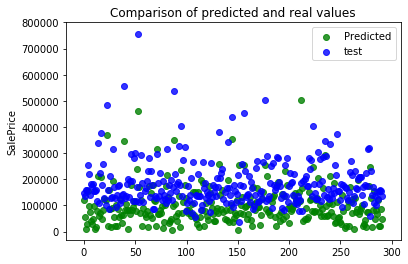

In [32]:
id=range(0,len(ytest_hat),1)
plt.scatter(id, ytest_hat, color='green',marker="o",alpha=0.8) 
plt.scatter(id, y_test, color='blue',marker="o",alpha=0.8)
plt.ylabel('SalePrice')
plt.title('Comparison of predicted and real values')
plt.legend(['Predicted', 'test'])
plt.show

In [33]:
# Test score for accuracy
u=((y_test - ytest_hat) ** 2).sum()
v=((y_test - ytest_hat.mean()) ** 2).sum()
r_squared=1-(u/v)
r_squared

SalePrice    0.130265
dtype: float64

In [34]:
# Training score for accuracy
u=((y_train - y_hat) ** 2).sum()
v=((y_train - y_hat.mean()) ** 2).sum()
r_squared=1-(u/v)
r_squared

SalePrice    0.070644
dtype: float64